In [1]:
import matplotlib.pyplot as plt
import nltk
from nltk import tokenize
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import re
import seaborn as sns
import string
from collections import Counter
from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ruslanishakov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ruslanishakov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ruslanishakov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ruslanishakov/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
from tqdm.notebook import tqdm_notebook

tqdm_notebook().pandas()

0it [00:00, ?it/s]

In [3]:
pickl_h_train = pd.read_pickle('dataset/outfox/human/train_humans.pkl')
pickl_h_test = pd.read_pickle('dataset/outfox/human/test_humans.pkl')
pickl_h_valid = pd.read_pickle('dataset/outfox/human/valid_humans.pkl')
df_human_test = pd.DataFrame(pickl_h_test)
df_human_train = pd.DataFrame(pickl_h_train)
df_human_valid = pd.DataFrame(pickl_h_valid)
df_human = pd.concat([df_human_train, df_human_test, df_human_valid], ignore_index=True)
df_human.rename(columns={0: 'text'}, inplace=True)
df_human['generated'] = 0
df_human

,text,generated
0,Driverless cars have always been seen and thou...,0
1,The Electoral College is only taking your pers...,0
2,Distance learning recently started being consi...,0
3,Distractions while driving could lead to death...,0
4,Would having car free cities be easier for eve...,0
...,...,...
15395,"Should students have classes from home, base i...",0
15396,Driveress cars are in our future because of al...,0
15397,Are dreiverless cars a good idea for the futur...,0
15398,Sometimes school can be to much for a person. ...,0


In [4]:
pickl_davinci_train = pd.read_pickle('dataset/outfox/davinci/train_lms_davinci.pkl')
pickl_davinci_test = pd.read_pickle('dataset/outfox/davinci/test_lms_davinci.pkl')
pickl_davinci_valid = pd.read_pickle('dataset/outfox/davinci/valid_lms_davinci.pkl')
df_davinci_train = pd.DataFrame(pickl_davinci_train)
df_davinci_test = pd.DataFrame(pickl_davinci_test)
df_davinci_valid = pd.DataFrame(pickl_davinci_valid)
df_davinci = pd.concat([df_davinci_train, df_davinci_test, df_davinci_valid], ignore_index=True)
df_davinci.rename(columns={0: 'text'}, inplace=True)
df_davinci['generated'] = 1
df_davinci

,text,generated
0,\nDriverless cars have been heralded as a grou...,1
1,The Electoral College system is controversial ...,1
2,The global coronavirus pandemic has had signi...,1
3,Texting and driving is distracting and dangero...,1
4,The growth of urbanism and improved transporta...,1
...,...,...
15395,"In the digital age, the age-old debate of whet...",1
15396,Driverless cars could dramatically reduce the ...,1
15397,Driverless cars could revolutionize contempora...,1
15398,Going to school can be a bit of a bummer. Writ...,1


In [5]:
df = pd.concat([df_human, df_davinci], ignore_index=True)
df

,text,generated
0,Driverless cars have always been seen and thou...,0
1,The Electoral College is only taking your pers...,0
2,Distance learning recently started being consi...,0
3,Distractions while driving could lead to death...,0
4,Would having car free cities be easier for eve...,0
...,...,...
30795,"In the digital age, the age-old debate of whet...",1
30796,Driverless cars could dramatically reduce the ...,1
30797,Driverless cars could revolutionize contempora...,1
30798,Going to school can be a bit of a bummer. Writ...,1


In [6]:
df['generated'].value_counts()

0    15400
1    15400
Name: generated, dtype: int64

In [7]:
df[df.duplicated(keep=False) == True]['generated'].value_counts()

0    170
Name: generated, dtype: int64

In [8]:
df = df.drop_duplicates()
df

,text,generated
0,Driverless cars have always been seen and thou...,0
1,The Electoral College is only taking your pers...,0
2,Distance learning recently started being consi...,0
3,Distractions while driving could lead to death...,0
4,Would having car free cities be easier for eve...,0
...,...,...
30795,"In the digital age, the age-old debate of whet...",1
30796,Driverless cars could dramatically reduce the ...,1
30797,Driverless cars could revolutionize contempora...,1
30798,Going to school can be a bit of a bummer. Writ...,1


In [9]:
def tokenize_and_clean_text(text):
    tokens = tokenize.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    punct_chars = string.punctuation + "'s" + '""' + '...' + "''" + '``'
    filtered_tokens = [word.lower() for word in tokens if word not in stop_words and word not in punct_chars]
    return filtered_tokens

def lemmatize(tokens):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

def get_mean_sent_char_length(sent_tokens):
    return np.mean([len(sent) for sent in sent_tokens])

def get_mean_sent_word_length(sent_tokens):
    return np.mean([len(sent.split()) for sent in sent_tokens])

def new_lines_quantity(text):
    pattern = r'(\n)'
    matches = re.findall(pattern, text)
    return len(matches)

In [10]:
df['BoW_raw'] = df['text'].progress_apply(tokenize_and_clean_text)

  0%|          | 0/30715 [00:00<?, ?it/s]

/var/folders/qr/1czxs48x1jx3pgl16wbvvqwm0000gn/T/ipykernel_15295/1126705616.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BoW_raw'] = df['text'].progress_apply(tokenize_and_clean_text)


In [12]:
df.loc[:, 'text_length'] = df['BoW_raw'].apply(lambda x: len(x))

/Users/ruslanishakov/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [13]:
df.loc[:, 'average_word_length'] = df['BoW_raw'].apply(lambda x: np.mean([len(word) for word in x if word.isalpha()]))

In [14]:
print(df['text_length'].min())
print(df['text_length'].max())
print(df['text_length'].mean())

12
1095
252.92156926583104


In [15]:
df.loc[:, 'text_sent_length'] = df.loc[:, 'text'].progress_apply(tokenize.sent_tokenize).apply(len)

  0%|          | 0/30715 [00:00<?, ?it/s]

In [16]:
df.loc[:,'mean_sentence_length_chars'] = df['text'].progress_apply(tokenize.sent_tokenize).apply(get_mean_sent_char_length)

  0%|          | 0/30715 [00:00<?, ?it/s]

In [17]:
df.loc[:, 'mean_sentence_length_words'] = df['text'].progress_apply(tokenize.sent_tokenize).apply(get_mean_sent_word_length)

  0%|          | 0/30715 [00:00<?, ?it/s]

In [18]:
df['BoW_lemmatized'] = df['BoW_raw'].progress_apply(lemmatize)

  0%|          | 0/30715 [00:00<?, ?it/s]

/var/folders/qr/1czxs48x1jx3pgl16wbvvqwm0000gn/T/ipykernel_15295/3186995282.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BoW_lemmatized'] = df['BoW_raw'].progress_apply(lemmatize)


In [19]:
df.loc[:, 'tokens_num'] = df.loc[:, 'BoW_lemmatized'].apply(len).astype('int16')

In [20]:
df.loc[:, 'unique_words'] = df.loc[:, 'BoW_raw'].apply(lambda x: len(set(x)))
df.loc[:, 'unique_ratio'] = df.loc[:, 'unique_words'] / df.loc[:, 'BoW_raw'].apply(len)

In [21]:
df.loc[:, 'new_lines_quant'] = df.loc[:, 'text'].apply(new_lines_quantity)

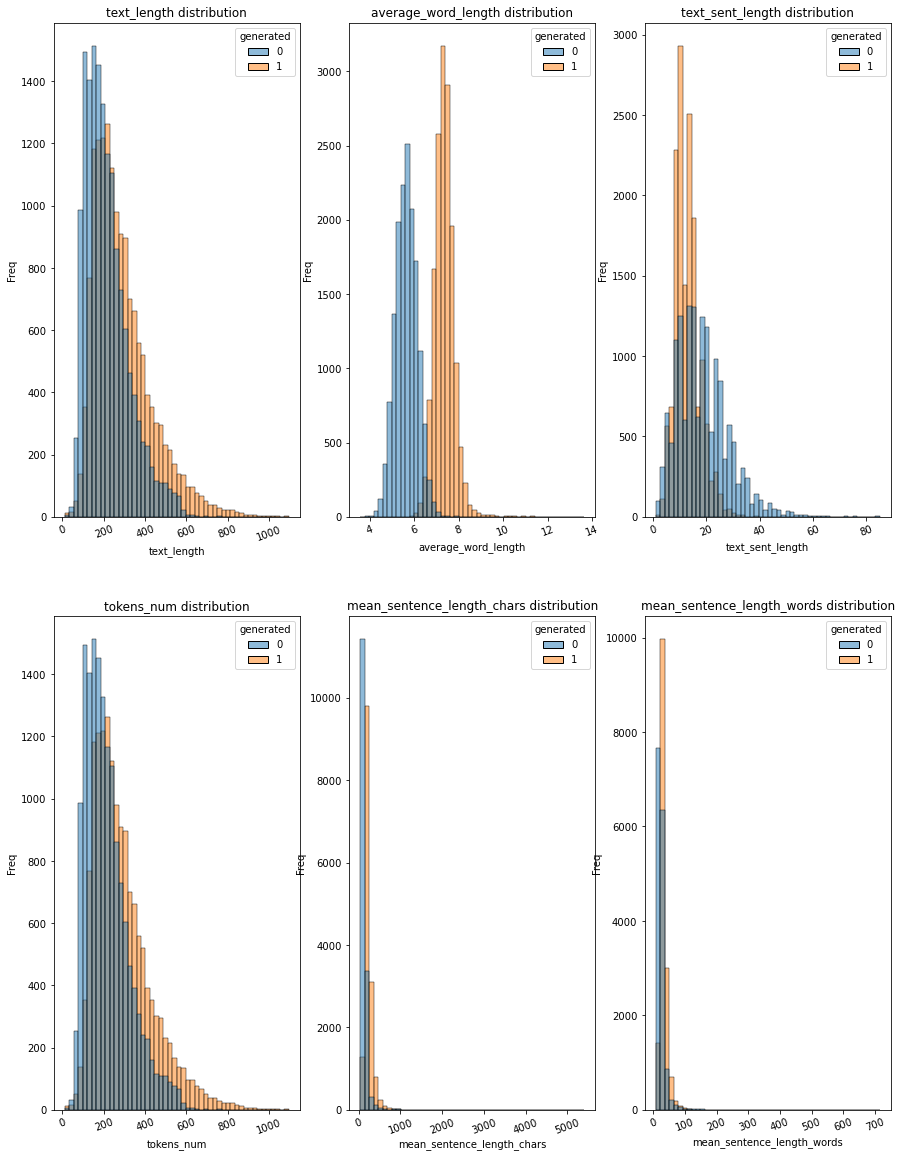

In [22]:
num_cols = df[['text_length', 'average_word_length', 'text_sent_length', 'tokens_num', 'mean_sentence_length_chars', 'mean_sentence_length_words']].columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 20))
for ax, col in zip(axes.flatten(), num_cols):
    sns.histplot(data=df, x=df[col], hue='generated', ax=ax, bins=50)
    ax.set_title(f'{col} distribution')
    ax.set_xlabel(f'{col}')
    ax.set_ylabel('Freq')
    ax.tick_params(axis='x', labelrotation=20)

In [23]:
print(df[df['generated'] == 0]['text_length'].skew())
print(df[df['generated'] == 1]['text_length'].skew())

1.08573259812123
1.2434284391175963


In [24]:
print(df[df['generated'] == 0]['text_sent_length'].skew())
print(df[df['generated'] == 1]['text_sent_length'].skew())

0.9563172817561583
0.8292443501518102


In [25]:
print(df[df['generated'] == 0]['text_length'].kurtosis())
print(df[df['generated'] == 1]['text_length'].kurtosis())

1.097144347395175
1.8448663953922302


In [26]:
print(df[df['generated'] == 0]['text_sent_length'].kurtosis())
print(df[df['generated'] == 1]['text_sent_length'].kurtosis())

1.674378569219753
1.1395259396637187


In [27]:
pd.options.display.float_format = '{:,.2f}'.format

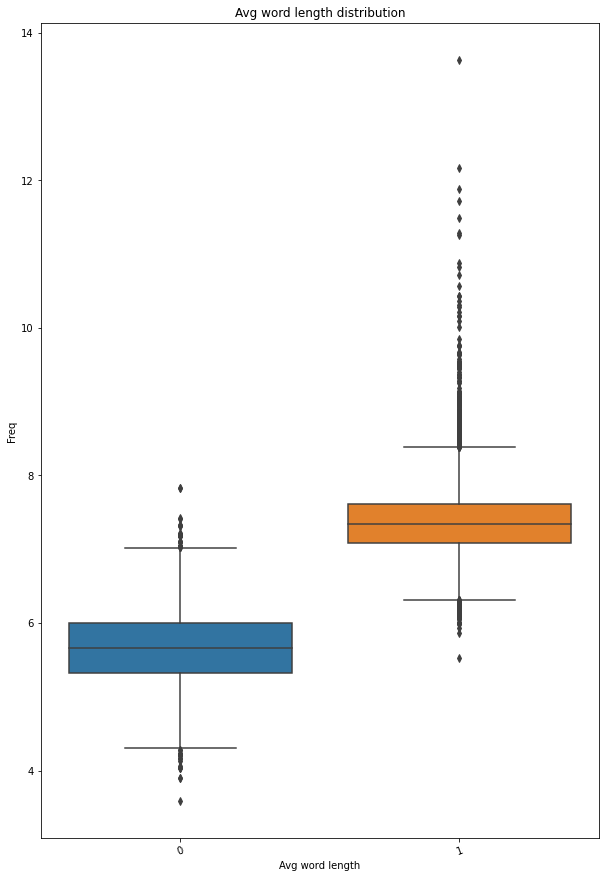

In [29]:
fig, ax = plt.subplots(figsize=(10, 15))
sns.boxplot(data=df, x='generated', y='average_word_length', ax=ax)
ax.set_title(f'Avg word length distribution')
ax.set_xlabel(f'Avg word length')
ax.set_ylabel('Freq')
ax.tick_params(axis='x', labelrotation=20)

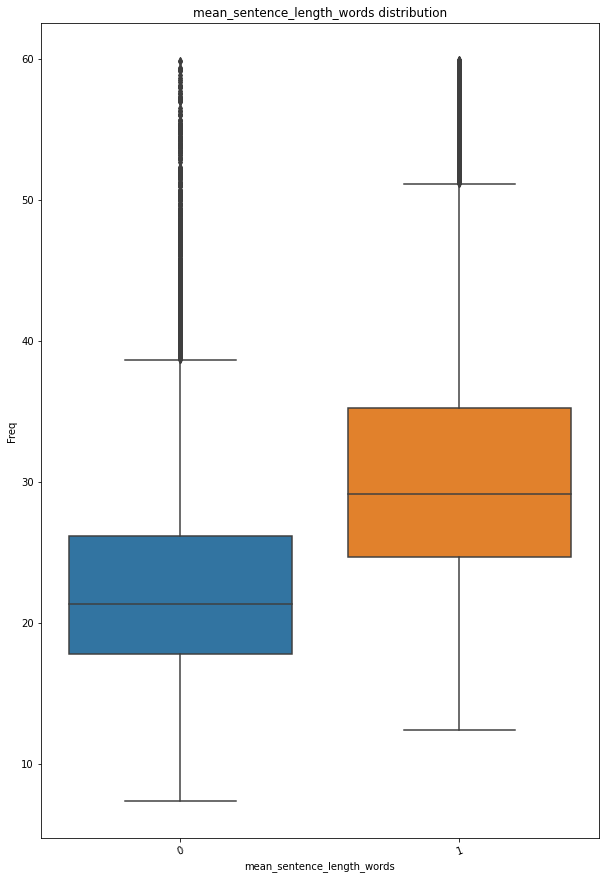

In [31]:
# Outliers > 60 are removed from boxplot
fig, ax = plt.subplots(figsize=(10, 15))
sns.boxplot(data=df, x='generated', y=df[df['mean_sentence_length_words'] < 60]['mean_sentence_length_words'], ax=ax)
ax.set_title(f'mean_sentence_length_words distribution')
ax.set_xlabel(f'mean_sentence_length_words')
ax.set_ylabel('Freq')
ax.tick_params(axis='x', labelrotation=20)

In [32]:
cnt = Counter()
df['BoW_raw'].progress_apply(lambda x: ''.join(x)).progress_apply(cnt.update)
cnt

  0%|          | 0/30715 [00:00<?, ?it/s]

  0%|          | 0/30715 [00:00<?, ?it/s]

Counter({'d': 1988297,
         'r': 3246184,
         'i': 4280538,
         'v': 815719,
         'e': 6698708,
         'l': 2722445,
         's': 4012432,
         'c': 2337716,
         'a': 3731036,
         'w': 535163,
         'y': 840721,
         'n': 3905825,
         't': 4061666,
         'h': 1141945,
         'o': 3391615,
         'u': 1656827,
         'g': 1453708,
         'm': 1347521,
         'p': 1512701,
         'j': 75415,
         'k': 405191,
         'f': 748560,
         'b': 571159,
         'x': 154861,
         'z': 54907,
         '2': 15166,
         '-': 72851,
         '.': 14266,
         '3': 7563,
         '1': 16827,
         "'": 41923,
         '9': 8044,
         '_': 4075,
         '6': 5406,
         '7': 6205,
         'q': 68127,
         '5': 7081,
         '0': 24514,
         ',': 1674,
         '/': 5640,
         '4': 5271,
         '8': 5526,
         '´': 261,
         '~': 111,
         '\x92': 89,
         'ã': 141,
         '\

In [33]:
cnt_lemm = Counter()
df['BoW_lemmatized'].progress_apply(cnt_lemm.update)
lemm_unigramms = cnt_lemm.most_common()
lemm_unigramms

  0%|          | 0/30715 [00:00<?, ?it/s]

[('student', 102688),
 ('people', 51211),
 ('would', 50864),
 ('car', 50820),
 ('school', 50078),
 ('i', 45463),
 ('the', 43606),
 ('one', 37964),
 ('time', 33844),
 ('could', 33260),
 ('help', 30255),
 ("n't", 30202),
 ('make', 28354),
 ('also', 28085),
 ('get', 27168),
 ('like', 26517),
 ('many', 25734),
 ('class', 25000),
 ('state', 24361),
 ('learning', 24048),
 ('project', 23917),
 ('vote', 23289),
 ('phone', 23246),
 ('in', 23135),
 ('electoral', 22453),
 ('activity', 22412),
 ('way', 22352),
 ('may', 21810),
 ('college', 21762),
 ('need', 21419),
 ('teacher', 21144),
 ('even', 20828),
 ('work', 20288),
 ('’', 20135),
 ('system', 19995),
 ('this', 19947),
 ('it', 19855),
 ('life', 19542),
 ('better', 18991),
 ('think', 18947),
 ('take', 17864),
 ('technology', 17832),
 ('use', 17306),
 ('thing', 17098),
 ('driving', 16837),
 ('opinion', 16645),
 ('online', 16529),
 ('advice', 16294),
 ('benefit', 15984),
 ('decision', 15886),
 ('good', 15731),
 ('venus', 15467),
 ('want', 14922),

In [34]:
cnt_lemm.most_common(20)

[('student', 102688),
 ('people', 51211),
 ('would', 50864),
 ('car', 50820),
 ('school', 50078),
 ('i', 45463),
 ('the', 43606),
 ('one', 37964),
 ('time', 33844),
 ('could', 33260),
 ('help', 30255),
 ("n't", 30202),
 ('make', 28354),
 ('also', 28085),
 ('get', 27168),
 ('like', 26517),
 ('many', 25734),
 ('class', 25000),
 ('state', 24361),
 ('learning', 24048)]

In [35]:
unigrams = {key: value for key, value in lemm_unigramms}
unigrams

{'student': 102688,
 'people': 51211,
 'would': 50864,
 'car': 50820,
 'school': 50078,
 'i': 45463,
 'the': 43606,
 'one': 37964,
 'time': 33844,
 'could': 33260,
 'help': 30255,
 "n't": 30202,
 'make': 28354,
 'also': 28085,
 'get': 27168,
 'like': 26517,
 'many': 25734,
 'class': 25000,
 'state': 24361,
 'learning': 24048,
 'project': 23917,
 'vote': 23289,
 'phone': 23246,
 'in': 23135,
 'electoral': 22453,
 'activity': 22412,
 'way': 22352,
 'may': 21810,
 'college': 21762,
 'need': 21419,
 'teacher': 21144,
 'even': 20828,
 'work': 20288,
 '’': 20135,
 'system': 19995,
 'this': 19947,
 'it': 19855,
 'life': 19542,
 'better': 18991,
 'think': 18947,
 'take': 17864,
 'technology': 17832,
 'use': 17306,
 'thing': 17098,
 'driving': 16837,
 'opinion': 16645,
 'online': 16529,
 'advice': 16294,
 'benefit': 15984,
 'decision': 15886,
 'good': 15731,
 'venus': 15467,
 'want': 14922,
 'go': 14851,
 'home': 14816,
 'know': 14512,
 'driverless': 14140,
 'new': 14085,
 'a': 13672,
 'differe

In [36]:
def get_words_as_text(tokens):
    return ' '.join(tokens)

In [37]:
words = df['BoW_raw'].apply(get_words_as_text)
words_as_texts = ' '.join(words)
all_words = words_as_texts.split()

In [38]:
bigrams = nltk.ngrams(all_words, 2)
cnt_bigrams = Counter(bigrams)
bigr = cnt_bigrams.most_common()

In [39]:
bigrams_freq = {' '.join(key): value for key, value in bigr}
bigrams_freq

{'electoral college': 16931,
 'driverless cars': 9935,
 'i think': 6490,
 'community service': 6180,
 'cell phones': 5896,
 'distance learning': 4908,
 'popular vote': 4698,
 'united states': 4492,
 'extracurricular activities': 4407,
 'for example': 4187,
 'online classes': 3937,
 'the electoral': 3914,
 'summer projects': 3902,
 'cell phone': 3883,
 'in conclusion': 3827,
 'one person': 3369,
 'i believe': 3163,
 'students would': 3159,
 'many people': 3043,
 'face mars': 2886,
 'car usage': 2877,
 'multiple opinions': 2821,
 'classes home': 2788,
 "ca n't": 2732,
 "would n't": 2726,
 'multiple people': 2607,
 'driverless car': 2298,
 'i would': 2268,
 'college system': 2126,
 'many students': 2061,
 "wo n't": 2032,
 'electoral votes': 1996,
 'extracurricular activity': 1994,
 'seagoing cowboys': 1969,
 'high school': 1959,
 'even though': 1871,
 'texting driving': 1829,
 'facial action': 1813,
 'action coding': 1761,
 'coding system': 1655,
 'attend classes': 1614,
 'b average': 160

In [40]:
trigrams = nltk.ngrams(all_words, 3)
cnt_trigrams = Counter(trigrams)
trigr = cnt_trigrams.most_common()

In [41]:
trigrams_freq = {' '.join(key): value for key, value in trigr}
trigrams_freq

{'the electoral college': 3681,
 'electoral college system': 2048,
 'facial action coding': 1726,
 'action coding system': 1531,
 'seeking multiple opinions': 1228,
 'use cell phones': 1224,
 'attend classes home': 1197,
 'limiting car usage': 1166,
 'president united states': 995,
 'seagoing cowboys program': 873,
 'cell phones school': 844,
 'cell phone use': 829,
 'make better choice': 743,
 'the face mars': 731,
 'ask one person': 705,
 'students would benefit': 690,
 'electoral college unfair': 634,
 'able attend classes': 617,
 'online video conferencing': 612,
 'advice multiple people': 594,
 'seeking advice multiple': 590,
 'on one hand': 588,
 'challenge exploring venus': 549,
 'election popular vote': 541,
 'one extracurricular activity': 537,
 'asking multiple people': 533,
 'the challenge exploring': 524,
 'cell phones driving': 521,
 'electoral college process': 517,
 'ask multiple people': 517,
 'i think students': 517,
 'benefit able attend': 514,
 'one person advice': 5

In [42]:
def get_pos(tokens):
    return [tag for word, tag in nltk.pos_tag(tokens, lang='eng')]

In [43]:
cnt_pos = Counter()
df['BoW_raw'].progress_apply(get_pos).apply(cnt_pos.update)
pos_count = cnt_pos.most_common()
pos_count

  0%|          | 0/30715 [00:00<?, ?it/s]

[('NN', 2094646),
 ('JJ', 1399019),
 ('NNS', 1214299),
 ('RB', 519674),
 ('VBG', 514831),
 ('VBP', 432493),
 ('VB', 247081),
 ('IN', 233354),
 ('VBD', 231011),
 ('VBN', 178992),
 ('VBZ', 156879),
 ('MD', 134314),
 ('DT', 107518),
 ('CD', 86864),
 ('PRP', 52820),
 ('JJR', 42176),
 ('RBR', 22327),
 ('JJS', 18841),
 ('NNP', 16643),
 ('CC', 14662),
 ('WRB', 12557),
 ('TO', 5873),
 ('PRP$', 5822),
 ('RP', 5293),
 ('WDT', 4711),
 ('WP', 3728),
 ('FW', 3205),
 ('EX', 2630),
 ('RBS', 2322),
 (':', 1661),
 ('WP$', 717),
 ('POS', 613),
 ('UH', 311),
 ('PDT', 298),
 ('$', 157),
 ('NNPS', 88),
 ('SYM', 29),
 ("''", 27)]

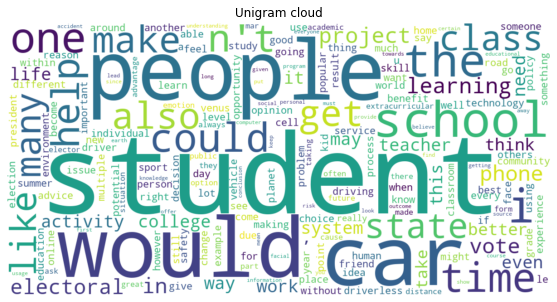

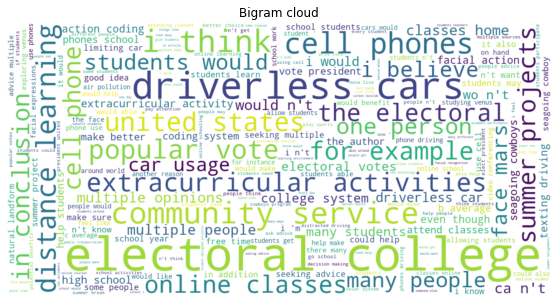

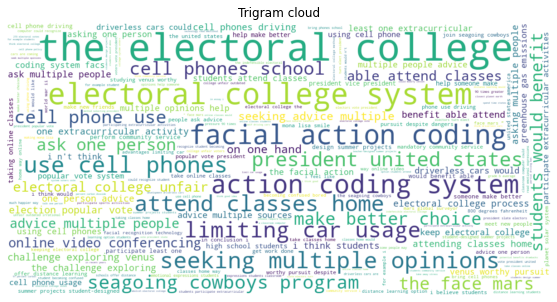

In [44]:
frequencies = unigrams, bigrams_freq, trigrams_freq
for feature in frequencies:
    wordcloud = WordCloud(width=1200, height=600, background_color='white').generate_from_frequencies(feature)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    if feature == unigrams:
        plt.title('Unigram cloud')
    elif feature == bigrams_freq:
        plt.title('Bigram cloud')
    else:
        plt.title('Trigram cloud')
    plt.axis('off')
    plt.show()

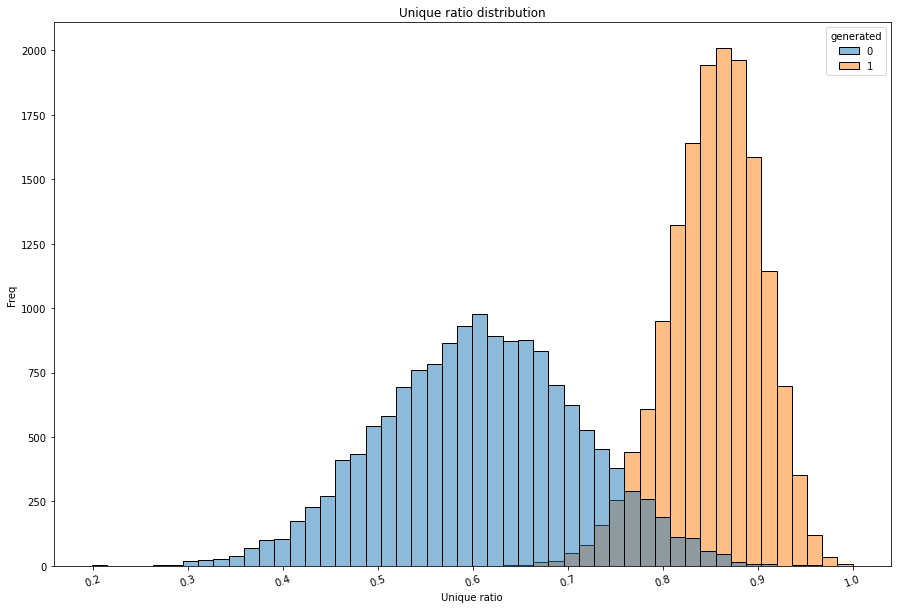

In [45]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.histplot(data=df, x='unique_ratio', hue='generated', ax=ax, bins=50)
ax.set_title(f'Unique ratio distribution')
ax.set_xlabel(f'Unique ratio')
ax.set_ylabel('Freq')
ax.tick_params(axis='x', labelrotation=20)

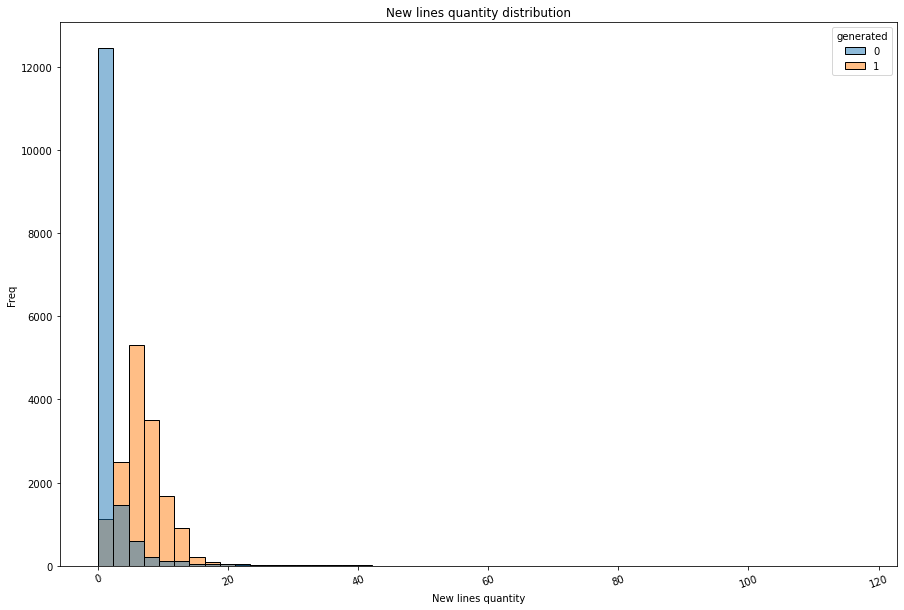

In [46]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.histplot(data=df, x='new_lines_quant', hue='generated', ax=ax, bins=50)
ax.set_title(f'New lines quantity distribution')
ax.set_xlabel(f'New lines quantity')
ax.set_ylabel('Freq')
ax.tick_params(axis='x', labelrotation=20)